# Getting started with Task 1

Instructions:
- Download the dataset from the [ECG Heartbeat Categorization Dataset](https://www.kaggle.com/datasets/shayanfazeli/heartbeat)
- Unzip the `archive.zip` file
- Rename the folder `archive` as `ecg_dataset` and place it in the root of the git repository

References:
- [ECG Heartbeat Classification: A Deep Transferable Representation](https://arxiv.org/pdf/1805.00794.pdf)

## Load dependencies

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## The PTB Diagnostic ECG Database

- Number of Samples: 14552
- Number of Categories: 2
- Sampling Frequency: 125Hz
- Data Source: Physionet's PTB Diagnostic Database
- ECG lead II re-sampled to the sampling frequency of 125Hz as the input (from [ECG Heartbeat Classification: A Deep Transferable Representation](https://arxiv.org/pdf/1805.00794.pdf))
- Remark: All the samples are cropped, downsampled and padded with zeroes if necessary to the fixed dimension of 188.
- The final element of each row denotes the class to which that example belongs.


The shape of the normal dataframe is :  (4046, 188)
Class :  0.0
The shape of the abnormal dataframe is :  (10506, 188)
Class :  1.0
The last time value is :  1488.0


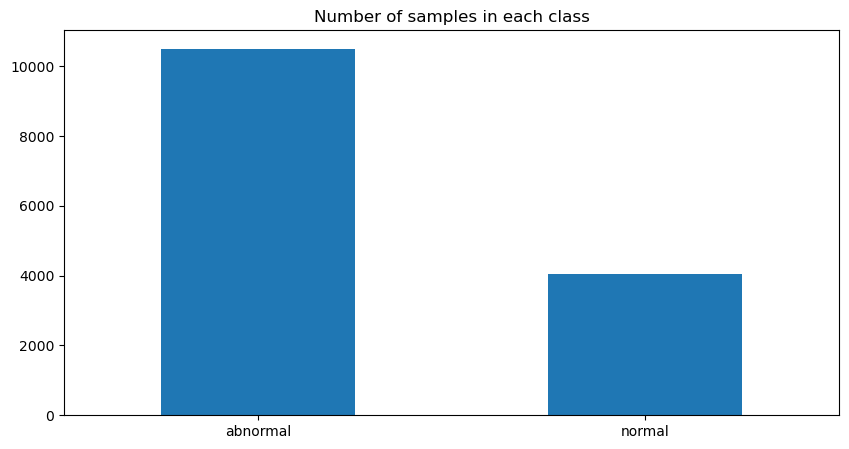

In [3]:
df_ptbd_normal = pd.read_csv("../ecg_dataset/ptbdb_normal.csv", header = None)
df_ptbd_abnormal = pd.read_csv("../ecg_dataset/ptbdb_abnormal.csv", header = None)

# print shapes of the dataframes
print("The shape of the normal dataframe is : ", df_ptbd_normal.shape)
# print one example of the last column
print("Class : ", df_ptbd_normal.iloc[:, -1][0])
print("The shape of the abnormal dataframe is : ", df_ptbd_abnormal.shape)
# print one example of the last column
print("Class : ", df_ptbd_abnormal.iloc[:, -1][0])

# classes are 0 (normal) and 1 (abnormal)
classes_names = {0 : "normal", 
                 1 : "abnormal"}

# get the number of columns in the dataframe
# the last column is the label/class
num_cols = df_ptbd_normal.shape[1] - 1 
# the signal was resampled at frequency of 125Hz as the input
# compute the time vector
time = np.arange(0, num_cols) / 125
# convert to milliseconds
time = time * 1000
# print last time value
print("The last time value is : ", time[-1])

# for the first "num_cols" and the time steps as column names
df_ptbd_normal.columns = list(time) + ["label"]
df_ptbd_abnormal.columns = list(time) + ["label"]

# concatenate the two dataframes
df_ptbd = pd.concat([df_ptbd_normal, df_ptbd_abnormal], axis = 0)

# count the number of samples in each class and plot a bar chart
# change the class names to "normal" and "abnormal"
# count the number of samples in each class
counts = df_ptbd["label"].value_counts()
# substitute the class names: 0.0 -> normal, 1.0 -> abnormal
counts.index = counts.index.map(classes_names)
# create a figure 
plt.figure(figsize = (10, 5))
# plot a bar chart
counts.plot(kind = "bar")
# plot xticks in angle
plt.xticks(rotation = 0)
plt.title("Number of samples in each class")
plt.show()

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler    
from sklearn.metrics import confusion_matrix, classification_report

x = df_ptbd.loc[:, df_ptbd.columns != "label"]
y = df_ptbd.loc[:, df_ptbd.columns == "label"]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, shuffle = True)


In [42]:
x_train.iloc[0]

0.0       1.000000
8.0       0.669378
16.0      0.251322
24.0      0.076861
32.0      0.000000
            ...   
1456.0    0.000000
1464.0    0.000000
1472.0    0.000000
1480.0    0.000000
1488.0    0.000000
Name: 5847, Length: 187, dtype: float64

In [185]:
import torch
x_train = torch.tensor(x_train.values, dtype = torch.float32)
x_test = torch.tensor(x_test.values, dtype = torch.float32)
y_train, y_test = torch.tensor(y_train.values, dtype = torch.float32),torch.tensor(y_test.values, dtype = torch.float32)

In [186]:
import torch.nn as nn

In [187]:
class LogisticRegression(torch.nn.Module):

    def __init__(self, x, y):
        super(LogisticRegression, self).__init__()
        self.linear1 = nn.Linear(x, 100)
        self.linear2 = nn.Linear(100, 50)
        self.linear3 = nn.Linear(50, y)

       #self.con1d = torch.nn.Conv1d(x, y)

    def forward(self, x):
        x = torch.relu(self.linear1(x))
        x = torch.relu(self.linear2(x))
        x = torch.relu(self.linear3(x))


        outputs = torch.sigmoid(x)
        return outputs

In [188]:
epochs = 100
input_dim = 187
output_dim = 1
learning_rate = 0.1
train_loss_tens = torch.empty(epochs)
val_loss_arr = np.zeros(epochs)

model = LogisticRegression(x = input_dim, y = output_dim)
criterion = torch.nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

In [189]:
for epoch in range(epochs):
    
    count_train_loss = 0.0
    
    
    pred_y = model(x_train)
    

    # Compute and print loss
    train_loss = criterion(pred_y, y_train)

    
    count_train_loss+= train_loss.item()
    
    train_loss_tens[epoch] = train_loss 

    # Zero gradients, perform a backward pass,
    # and update the weights.
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()
    #print(loss)
    #print(f'Epoch {epoch +1} \t\t Training Loss: {train_loss / len(x_train)} \t')
        
train_loss_arr = train_loss_tens.detach().numpy()

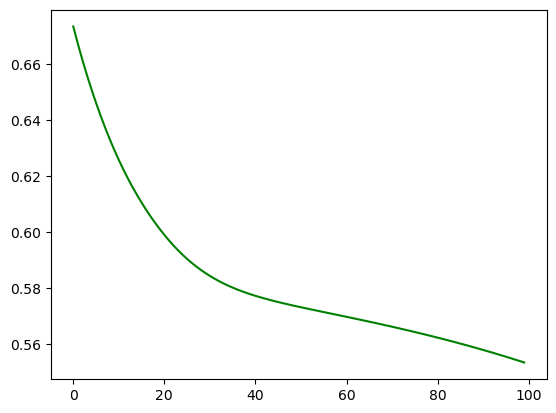

In [190]:
plt.plot(train_loss_arr, 'g')

In [191]:
with torch.no_grad():
    prediction = model(x_test)
    pred_class = prediction.round()
    accuracy = (pred_class.eq(y_test).sum())/float(y_test.shape[0])
    print(accuracy.item())

0.720797061920166
